## **Install dependencies**

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
repsol_path = '/content/repsol-ml4md'
repsol_utils_path = '/content/repsol-ml4md/utils'
repsol_data_path = '/content/repsol-ml4md/data'

# Make sure to adapt the following line
your_workshop_path = '/content/drive/My Drive/Colab Notebooks/repsol-ml4md/'
os.symlink(f'{your_workshop_path}predictive_models', repsol_path)
sys.path.insert(0, repsol_utils_path)
sys.path.insert(0, repsol_data_path)

Mounted at /content/drive


In [ ]:
%pip install rdkit-pypi
%pip install mordred
%pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git
%pip install ml-collections
%pip install gpflow

# **Descriptors-Based activity-structure relationship models**

For this part of the course, we are going to work with the Delaney dataset, which is included in MoleculeNet. It contains information about water solubility data (log solubility in mols per litre) for common organic small molecules.

We first load the libraries to be used in this lab.

In [3]:
import json
import itertools

import numpy as np
import pandas as pd

import rdkit
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem

import ml_collections

from mordred import Calculator, descriptors

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.set(style="whitegrid", font_scale=1.5)
plt.rcParams['lines.markersize'] = 7

## **Loading and preprocessing the data**

Let's load the data and extract some useful information

In [4]:
main_dir = './repsol-ml4md/'
data_dir = f'{main_dir}data/delaney/'
data_path = f'{data_dir}delaney.csv'
name = 'delaney'
smi_col = 'SMILES'
mol_col = 'mol'
target_column = 'measured log(solubility:mol/L)'

Here, we create a column that contains an object of the `rdkit.Chem.rdchem.Mol` class for each molecule. This class provides us with various information about each molecule, and we can also visualize it using it. The documentation for this class is comprehensive and can be found at 
[https://www.rdkit.org/docs/GettingStartedInPython.html](https://www.rdkit.org/docs/GettingStartedInPython.html)

In [5]:
df = pd.read_csv(data_path)
df[mol_col] = df[smi_col].apply(Chem.MolFromSmiles)

For instance, we can visualize the first molecule in the dataset using

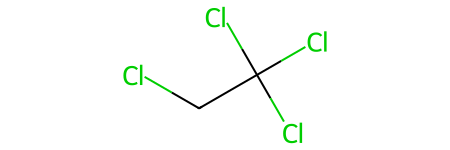

In [6]:
first = df["mol"].iloc[0]
first

To get the number of atoms, we use:

In [7]:
first.GetNumAtoms()

6

We use the following to obtain canonical SMILES

In [8]:
df['can_SMILES'] = df[mol_col].apply(lambda mol: Chem.MolToSmiles(mol, canonical=True)).values

We remove molecules with duplicated canonical SMILES

In [9]:
df = df.drop_duplicates('can_SMILES').reset_index(drop=True)

Here, we are extracting the range of the number of atoms present in the molecules of the dataset.

In [10]:
natoms = df[mol_col].apply(lambda m: m.GetNumAtoms()).values
natoms_range = (int(np.min(natoms)), int(np.max(natoms)))
n_mols = len(df['can_SMILES'].unique())

natoms_range

(2, 55)

Finally, we obtain the atoms set (this is slightly more involved)

In [11]:
def get_atom_set(mols):
    """Get atom set for a list of smiles."""
    atom_set = set()
    for m in mols:
        atom_set.update(set([a.GetSymbol() for a in m.GetAtoms()]))
    table = rdkit.Chem.GetPeriodicTable()
    # We can sort atoms by atomic number
    atom_num = [table.GetAtomicNumber(a) for a in atom_set]
    atom_set = [a for _, a in sorted(zip(atom_num, atom_set))]
    return atom_set


atom_set = get_atom_set(df[mol_col])
atom_set

['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I']

It is a good practice to save this info in a config file for the dataset

In [12]:
info =     {"name"           : "delaney",
            "atom_set"       : atom_set,
            "natom_range"    : natoms_range,
            "n_datapoints"   : len(df),
            "n_mols"         : n_mols,
            "target_column"  : target_column,
            "smiles_column"  : 'can_SMILES'}

# ConfigDict allows dot access to elements
info = ml_collections.ConfigDict(info)
fname = os.path.join(data_dir, f'{name}.json')
with open(fname, 'w') as afile:
    afile.write(info.to_json())

If we want to recover this info

In [13]:
with open(fname, 'r') as afile:
    config = ml_collections.ConfigDict(json.load(afile))

We also save the preprocessed dataset in a `.csv` file

In [14]:
fname = os.path.join(data_dir, f'{name}_preprocessed.csv')
df.to_csv(fname, index = False)

## **Calculating features**

This section involves computing two of the most frequently used features for describing molecules, namely Morgan Fingerprints and Mordred descriptors. To do so, we begin by loading all the necessary data.

In [15]:
fname = os.path.join(data_dir, f'{name}.json')
with open(fname, 'r') as afile:
    config = ml_collections.ConfigDict(json.load(afile))

fname = os.path.join(data_dir, f'{name}_preprocessed.csv')
df = pd.read_csv(fname)
df["mol"] = df[config.smiles_column].apply(Chem.MolFromSmiles)
smiles = np.array(df[config.smiles_column].tolist())

### **Morgan Fingerprints**

Morgan Fingerprints, also known as circular fingerprints or extended-connectivity fingerprints, are a type of molecular fingerprint that encodes the topology of a molecule. They are widely used in cheminformatics and drug discovery, not only in QSAR modelling, but also as a method of comparing and clustering molecules based on their structural similarities.

Morgan fingerprints are generated by considering atom-centered environments surrounding each atom in a molecule, up to a certain radius. The atoms and bonds within this radius are converted into a unique bitstring that enocodes relevangt information about the molecular topology. The resulting fingerprints are binary vectors of fixed length.

Morgan fingerprints are highly efficient and can be computed rapidly, making them well-suited for large-scale virtual screening and similarity searching. They have been shown to perform well in a variety of applications, including compound clustering and target prediction.

For a more detailed explanation of Morgan Fingerprints, you can refer to the extended description provided in the following publication: 
[https://pubs.acs.org/doi/10.1021/ci100050t](https://pubs.acs.org/doi/10.1021/ci100050t).

We can calculate these features using the following code

In [16]:
desc = df['mol'].apply(lambda mol : 
                       AllChem.GetMorganFingerprintAsBitVect(mol, radius = 3, nBits = 2048) )
##
values = np.array([np.array(v) for v in desc]).astype(np.float32)
##
np.savez_compressed(data_dir + "features_mfp.npz", cansmiles=smiles, values=values)

### **Mordred Descriptors**

Mordred descriptors are a type of molecular descriptor that encode a wide range of physicochemical properties and structural features of a molecule. They are used in cheminformatics and drug discovery as a method of characterizing and comparing molecules based on their chemical properties.

Mordred descriptors are calculated by analyzing the 2D or 3D structure of a molecule and calculating a set of pre-defined molecular properties and characteristics. These properties can include things such as molecular weight, topological polar surface area, hydrogen bond donors and acceptors, and many others.

Mordred descriptors can be calculated for small molecules, peptides, and other complex structures. They are highly versatile and can be used for a wide range of applications, such as predicting biological activity, compound clustering, and virtual screening.

The Mordred descriptors were originally proposed in a research paper, which can be accessed at the following link: [https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y)

We can calculate them using:


In [ ]:
calc = Calculator(descriptors, ignore_3D=True)
##
desc = df['mol'].apply(lambda mol : 
                       calc(mol)._values )
##
values = np.array([np.array(v) for v in desc]).astype(np.float32)

This is a bit slow. We can speed it up using

In [ ]:
df_modred = calc.pandas(df['mol'], nproc=7).fill_missing(value=np.nan)
values = df_modred.values.astype(np.float32)
np.savez_compressed(data_dir + "features_mordred.npz", cansmiles=smiles, values=values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1116/1116 [04:16<00:00,  4.35it/s]


### **Splitting molecules**

In order to properly evaluate predictive models, we splite molecules in train, test and validations sets.

In [17]:
test_size  = 0.2
val_size   = 0.1
train_size = 0.7
##
seed = 83
smi_train, smi_test = train_test_split(smiles, random_state=seed, test_size=test_size)
smi_train, smi_val = train_test_split(smi_train, random_state=seed,
                                      test_size=val_size / (train_size + val_size))


# check split train and validation
for a, b in itertools.combinations([smi_train, smi_val, smi_test], 2):
    assert np.intersect1d(a, b).size == 0, 'Found bad split!'  # ensure no intersection between splits

np.savez_compressed(data_dir + "smi_split.npz", train=smi_train, val=smi_val, test=smi_test)

## **Training deterministic predictive models**

Before we can proceed with fitting various models, we need to set up the stage. We have developed a function for that.


In [18]:
from utils import IndexSplit, ArraySplit, ScaledArraySplit

def load_task(feature_set, x_scaler, y_scaler):
    smi_split = np.load(f'{data_dir}smi_split.npz')
    smi_dict  = {key: smi_split[key] for key in smi_split.keys()}
    ##
    y = df[config.target_column].values.reshape(-1, 1)
    ##
    indices = {}
    for key, smi in smi_dict.items():
        indices[key] = np.array(df[np.isin(smiles, smi)].index.tolist())

    features = np.load(f'{data_dir}{feature_set}.npz')
    features  = {key: features[key] for key in features.keys()}
    features_values = features["values"]
    mask = np.logical_and(np.sum(np.isnan(features_values), axis=0) == 0, np.std(features_values, axis=0) > 0.0)
    features_values = features_values[:, mask]
    print(f'Masking {np.sum(np.logical_not(mask))} feature dims')
    split = IndexSplit(**indices)
    smi_split = ArraySplit(smiles, split)
    x = ScaledArraySplit(features_values, split, x_scaler)
    y = ScaledArraySplit(y, split, y_scaler)
    
    return smi_split, x, y

The function that prepares the data and features for analysis returns three objects:

* `smi_split`, which is an object of the `ArraySplit` class defined in `utils.py`. It contains two methods:
  - `smi_split.values`: returns the SMILES strings.
  - `smi_split.indices`: returns the indices that have been split into train, test, and validation sets.

* `x`, which is an object of the `ScaledArraySplit` class defined in `utils.py`. It contains the following methods:
  - `x.train`: contains the features of the molecules in the training set.
  - `x.val`: contains the features of the molecules in the validation set.
  - `x.test`: contains the features of the molecules in the test set.
  - `x.scaled_train`: contains the scaled features of the molecules in the training set. Scaling is computed using only the information in the training set.
  - `x.scaled_val`: contains the scaled features of the molecules in the validation set. Scaling is computed using only the information in the training set.
  - `x.scaled_test`: contains the scaled features of the molecules in the test set. Scaling is computed using only the information in the training set.

* `y`, which is an object of the `ScaledArraySplit` class defined in `utils.py`. It contains the following methods:
  - `y.train`: contains the outcomes of the molecules in the training set.
  - `y.val`: contains the outcomes of the molecules in the validation set.
  - `y.test`: contains the outcomes of the molecules in the test set.
  - `y.scaled_train`: contains the scaled outcomes of the molecules in the training set. Scaling is computed using only the information in the training set.
  - `y.scaled_val`: contains the scaled outcomes of the molecules in the validation set. Scaling is computed using only the information in the training set.
  - `y.scaled_test`: contains the scaled outcomes of the molecules in the test set. Scaling is computed using only the information in the training set.

The way in which the data is scaled depends on the type of model being employed. When using a linear regression or its variants, it is advisable to scale the features to ensure they are on the same scale. However, in the case of tree-based models, scaling is not necessary, as the relative order of the feature values is the only important factor.

### **1. Deterministic Models - MFP features**

We will demonstrate how to fit a deterministic model on the Morgan fingerprints using LassoCV. This model is a linear regression model that includes $L_1$ regularization to encourage sparsity in the coefficients. In addition, it uses cross-validation to select the optimal regularization parameter.
Additional information about the LassoCV model can be found at [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

We scale the features before fitting the model. We also scale the outcome.



In [19]:
feature_set = "features_mfp"
smi_split, x, y = load_task(feature_set, 'quantile', 'standard')

Masking 18 feature dims


We train the model and make predictions on the molecules of the test set. This will take few minutes!

In [20]:
from sklearn.linear_model import LassoCV

model = LassoCV()
model.fit(x.scaled_train, y.scaled_train[:, 0])
y_pred_test = model.predict(x.scaled_test)
y_ground_truth = y.scaled_test

*Note*: we can easily fit almost any `sklearn` model adapting the previouse chunk of code.

We can save results for latter evaluation

In [21]:
np.savez_compressed(f'{data_dir}predictions_LassoCV_{feature_set}.npz', y_pred=y_pred_test, y_true=y_ground_truth)

### **2. Deterministic Models - Mordred features**

We will demonstrate how to fit a deterministic model on the Mordred using a Random Forest model. As this is a tree-based model we choose not to scale the features.

In [22]:
feature_set = "features_mordred"
smi_split, x, y = load_task(feature_set, None, None)

Masking 646 feature dims


We train the model and make predictions on the molecules of the test set.

In [23]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x.scaled_train, y.scaled_train[:, 0])
y_pred_test = model.predict(x.scaled_test)
y_ground_truth = y.scaled_test

We can save results for latter evaluation

In [24]:
np.savez_compressed(f'{data_dir}predictions_RF_{feature_set}.npz', y_pred=y_pred_test, y_true=y_ground_truth)

## **Evaluating deterministic predictive models**

For evaluating deterministic predictions, we can use the usual metrics. We use the R2 score [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) For instance for the LassoCV model with MFP features

R2 score: 0.6717527183973135


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

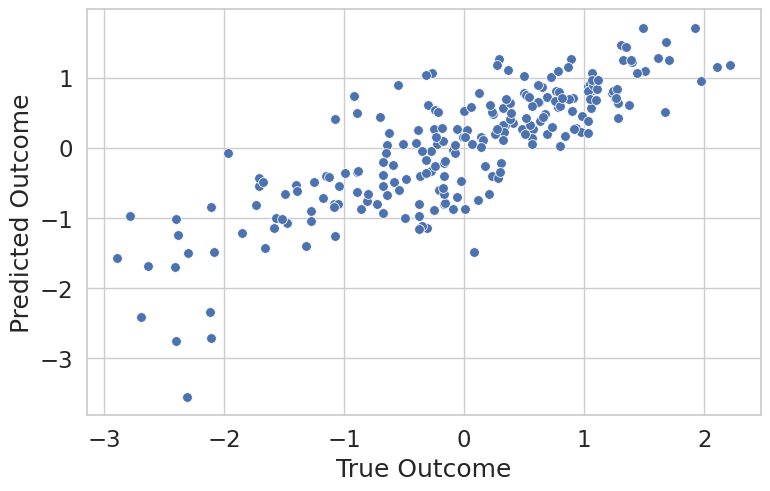

In [25]:
feature_set = "features_mfp"
preds = np.load(f'{data_dir}predictions_LassoCV_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

For Random Forest model with mordred features

R2 score: 0.9209473267644495


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

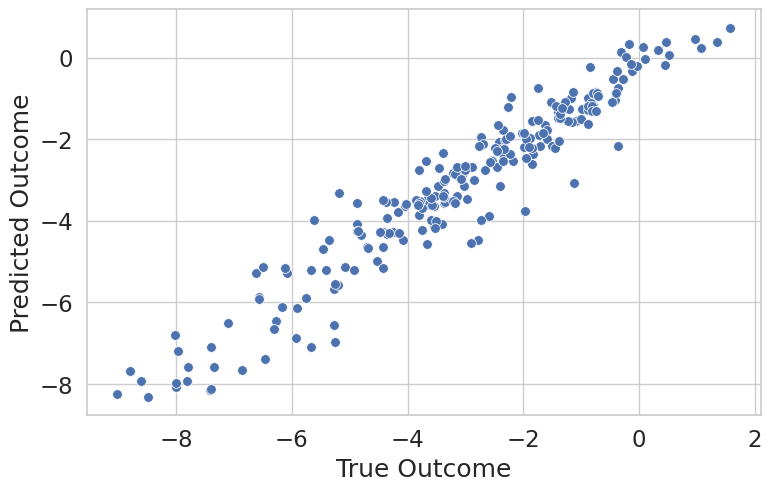

In [26]:
feature_set = "features_mordred"
preds = np.load(f'{data_dir}predictions_RF_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}
print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

## **Training probabilistic predictive models**

### **1. NGBoost - MFP and Mordred Features**

NGBoost is a probabilistic machine learning algorithm that allows for predictive uncertainty estimation using Gradient Boosting. Unlike traditional Gradient Boosting models that output point predictions, in NGBoost; the output given covariates is modelled through
$y \vert x \sim P_\theta (x)$. The model parameters $\theta(x)$ are obtained through an additive combination of $M$ base learners and an initial parameter $\theta^{(0)}$:

$$
\theta = \theta^{(0)} - \eta \sum_{m=1}^M \rho^{(m)}\cdot f^{(m)} (x)
$$

Here, $f^{(m)}(x)$ are the base learners that are trained on the data, and $\rho^{(m)}$ are weights assigned to each base learner. NGBoost optimizes the parameters by minimizing a **proper scoring rule**, which is a function that measures the quality of probabilistic predictions. The algorithm uses a refinement of **gradient boosting** for this purpose.

* For more information about NGBoost and its implementation, you can visit the following link: [https://arxiv.org/abs/1910.03225](https://arxiv.org/abs/1910.03225)

* To learn more about proper scoring rules go to [https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf)

We now train the model on Morgan Fingerprints and make predictions over the molecules in the test set.

In [27]:
from ngboost import NGBRegressor

class NGB():

    def __init__(self, n_estimators=2000, lr=0.005, tol=1e-4):

        self.model = NGBRegressor(n_estimators=n_estimators, 
                                  random_state=42, 
                                  learning_rate=lr, tol=tol)

    def train(self, X_train, y_train, X_val, y_val, patience=100, verbose=True):
        self.model.fit(X_train, y_train, X_val, y_val,
                       early_stopping_rounds=patience)

    def predict(self, X_test):
        y_dists = self.model.pred_dist(X_test)
        return y_dists.loc, np.sqrt(y_dists.var)



In [28]:
# NGBoost
feature_set = "features_mfp"
smi_split, x, y = load_task(feature_set, None, None)

model = NGB()
model.train(x.train, y.train, x.val, y.val)
y_mu, y_std = model.predict(x.test)

# Save results for later evaulation
np.savez_compressed(f'{data_dir}predictions_NGB_{feature_set}.npz', y_pred=y_mu,
                    y_std=y_std,  y_true=y.test)

Masking 18 feature dims
[iter 0] loss=2.1483 val_loss=2.1273 scale=1.0000 norm=1.7738


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 100] loss=1.9830 val_loss=2.0087 scale=1.0000 norm=1.5590
[iter 200] loss=1.8899 val_loss=1.9487 scale=1.0000 norm=1.4451
[iter 300] loss=1.8187 val_loss=1.9148 scale=1.0000 norm=1.3671
[iter 400] loss=1.7509 val_loss=1.8914 scale=1.0000 norm=1.3011
[iter 500] loss=1.6913 val_loss=1.8763 scale=1.0000 norm=1.2476
[iter 600] loss=1.6395 val_loss=1.8697 scale=1.0000 norm=1.2059
[iter 700] loss=1.5926 val_loss=1.8661 scale=1.0000 norm=1.1681
== Early stopping achieved.
== Best iteration / VAL691 (val_loss=1.8653)


Similarly, for Mordred features

In [ ]:
# NGBoost
feature_set = "features_mordred"
smi_split, x, y = load_task(feature_set, None, None)

model = NGB()
model.train(x.train, y.train, x.val, y.val)
y_mu, y_std = model.predict(x.test)

# Save results for later evaulation
np.savez_compressed(f'{data_dir}predictions_NGB_{feature_set}.npz', y_pred=y_mu,
                    y_std=y_std,  y_true=y.test)

Masking 646 feature dims


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[iter 0] loss=2.1483 val_loss=2.1191 scale=1.0000 norm=1.7738
[iter 100] loss=1.7745 val_loss=1.7635 scale=1.0000 norm=1.2308
[iter 200] loss=1.4351 val_loss=1.4517 scale=2.0000 norm=1.7246
[iter 300] loss=1.0848 val_loss=1.1588 scale=2.0000 norm=1.3769
[iter 400] loss=0.7994 val_loss=0.9578 scale=2.0000 norm=1.2126
[iter 500] loss=0.5861 val_loss=0.8783 scale=2.0000 norm=1.1146
[iter 600] loss=0.4494 val_loss=0.8844 scale=2.0000 norm=1.0560
== Early stopping achieved.
== Best iteration / VAL533 (val_loss=0.8720)


### **2. Gaussian Process Regression - MFP Features**

Gaussian Process Regression (GPR) is a non-parametric Bayesian approach to regression. It models the output variable as a Gaussian process, which can be interpreted as a distribution over functions. The model is defined by a mean function and a covariance function, which together specify the prior distribution over the space of functions. Given some observed data, the posterior distribution over functions can be calculated using Bayes' rule. This allows for predictive inference by computing the distribution over outputs at any new input point.

The key equation for GPR is:

$$
f(x_*) \mid X, f(X), x_* \sim \mathcal{N}(\mu_{x_*}, \sigma_{x_*}^2)
$$

where $f(x_*)$ is the predicted output at a new input point $x_*$, $X$ and $f(X)$ are the observed input-output pairs, and $\mu_{x_*}$ and $\sigma_{x_*}^2$ are the mean and variance of the posterior distribution over $f(x_*)$. The values of $\mu_{x_*}$ and $\sigma_{x_*}^2$ can be calculated **analytically**.

The choice of the covariance function or kernel function is crucial in Gaussian Process Regression (GPR). It determines the degree of smoothness, lengthscale, and other characteristics of the functions that the model considers plausible. The kernel function depends on the features used in the model. 

For example, for Morgan fingerprints, a suitable kernel is the Tanimoto kernel.

\begin{equation*}
k(x, x') = \frac{x \cdot x'}{\Vert x \Vert^2 + \Vert x' \Vert^2 - x \cdot x'}
\end{equation*}


On the other hand, for real-valued features, the RBF kernel is a common option

\begin{equation*}
 K(\mathbf {x} ,\mathbf {x'} )=\exp \left(-{\frac {\|\mathbf {x} -\mathbf {x'} \|^{2}}{2\sigma ^{2}}}\right)
 \end{equation*}

In [29]:
import numpy as np
import pandas as pd
import copy

import gpflow
from gpflow.mean_functions import Constant
from gpflow.utilities import positive
from gpflow.utilities.ops import broadcasting_elementwise

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf


class Tanimoto(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__()
        # We constrain the value of the kernel variance to be positive when it's being optimised
        self.variance = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X

        Xs = tf.reduce_sum(tf.square(X), axis=-1)  # Squared L2-norm of X
        X2s = tf.reduce_sum(tf.square(X2), axis=-1)  # Squared L2-norm of X2
        outer_product = tf.tensordot(X, X2, [[-1], [-1]])  # outer product of the matrices X and X2

        # Analogue of denominator in Tanimoto formula
        denominator = -outer_product + broadcasting_elementwise(tf.add, Xs, X2s)

        return self.variance * outer_product/denominator

    def K_diag(self, X):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))
    
class GPr:

    def __init__(self, input_dim, kernel='Tanimoto'):  
        if kernel == 'Tanimoto':
          self.kernel = Tanimoto()
        elif kernel == 'rbf':
          # use high dimensional kernel
          self.kernel = gpflow.kernels.SquaredExponential(
              lengthscales=[1.0 for _ in range(input_dim)])
        else:
          NotImplementedError('Not implemented kernel.')


    def fit(self, X_train, y_train):

        y_train = y_train.reshape(-1, 1)
        X_train = X_train.astype(np.float64)

    
        self.m = gpflow.models.GPR(data=(X_train, y_train), 
                                   mean_function=Constant(np.mean(y_train)), 
                              kernel=self.kernel)
        
        opt = gpflow.optimizers.Scipy()
        opt.minimize(self.m.training_loss, self.m.trainable_variables)


    def predict(self, X_test):

        X_test = X_test.astype(np.float64)
        y_mu, y_var = self.m.predict_f(X_test)


        return y_mu.numpy().squeeze(), np.sqrt(y_var.numpy().squeeze())


We first train the GPR on Morgan descriptors and make predictions over the molecules in the test set.

In [30]:
# GPr
feature_set = "features_mfp"
smi_split, x, y = load_task(feature_set, None, 'standard')

model = GPr(x.values.shape[-1], kernel='Tanimoto')
model.fit(x.scaled_train, y.scaled_train)
y_mu, y_std = model.predict(x.scaled_test)
np.savez_compressed(f'{data_dir}predictions_GPr_{feature_set}.npz', y_pred=y_mu,
                    y_std=y_std,  y_true=y.scaled_test)

Masking 18 feature dims


For Mordred descriptors, we choose the RBF kernel

In [ ]:
# GPr
feature_set = "features_mordred"
smi_split, x, y = load_task(feature_set, 'quantile', 'standard')

model = GPr(x.values.shape[-1], kernel='rbf')
model.fit(x.scaled_train, y.scaled_train)
y_mu, y_std = model.predict(x.scaled_test)
np.savez_compressed(f'{data_dir}predictions_GPr_{feature_set}.npz', y_pred=y_mu,
                    y_std=y_std,  y_true=y.scaled_test)

Masking 646 feature dims


## **Evaluating probabilistic predictive models**

There are multiple ways of evaluating quality of probabilistic forecasts. This is a whole research area itself. You can learn more at [https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf](https://sites.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf)


Here, we focus on calibration measures. Imagine that we construct $(100 \cdot q)$\% prediction intervals for the property prediction of every molecules in a test set. Let's call $C(q)$ to the proportion of the molecules in the test set whose property value is within the intervals calculated for such molecule.

* If $C(q) = q$ we say that the model is well calibrated.

* If $C(q) < q$ we say that the model is overconfident.

* If $C(q) < q$ we say that the model is underconfident.

If the predictive distribution for molecules with features $X$ is normal with mean $\mu(X)$ and standard deviation $\sigma(X)$, it is easy to prove that (try to do the math!)

\begin{equation*}
C(q) = \frac{1}{N} \sum_{i=1}^N \mathbb{1}\left[ \frac{\mu(X) - y_i}{\sigma(X)} < \Phi^{-1}\left(\frac{1+q}{2}\right) \right]
\end{equation*}

where $\Phi^{-1}$ is the inverse CDF of the standard normal distribution.

Thus, a way to test for calibration is to plot a grid of theoretical quantiles in the x-axis and their corresponding empirical quantile $C(q)$. If this line is close to $y=x$ then the model is well callibrated. We use the following functions for this purpose.




In [31]:
from scipy.stats import norm

def calibration(y_true, y_pred, y_err, q):
    lhs = np.abs((y_pred - y_true) / y_err)
    rhs = norm.ppf(((1.0 + q) / 2.0), loc=0., scale=1.)
    return np.sum((lhs < rhs).astype(int)) / y_true.shape[0]

def calibration_curve(y_true, y_pred, y_err, num_bins=10):
    qs = np.linspace(0, 1, num_bins)
    Cqs = np.empty(qs.shape)
    for ix, q in enumerate(qs):
        Cqs[ix] = calibration(y_true, y_pred, y_err, q)

    return qs, Cqs

def plot_calibration_curve(preds):
  qs, Cqs = calibration_curve(preds["y_true"].squeeze(), 
                              preds["y_pred"], preds["y_std"], num_bins=100)
  g = sns.scatterplot(x = qs, y = Cqs)
  g.set(xlabel='Theoretical Quantiles', ylabel='Empirical Quantiles')
  g.axline([0, 0], [1,1], c='gray')
  return ax

### **1. NGBoost - MFP features**

R2 score: 0.5419371459935121


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

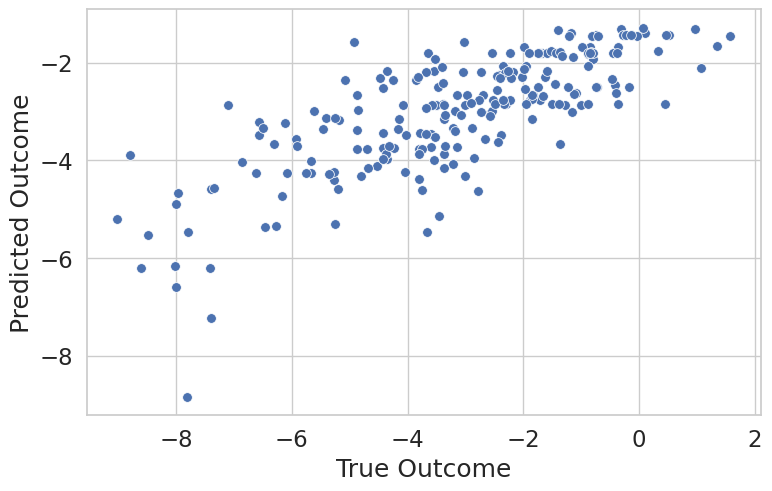

In [32]:
feature_set = "features_mfp"
preds = np.load(f'{data_dir}predictions_NGB_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

Calibration plot

<Axes: xlabel='True Outcome', ylabel='Predicted Outcome'>

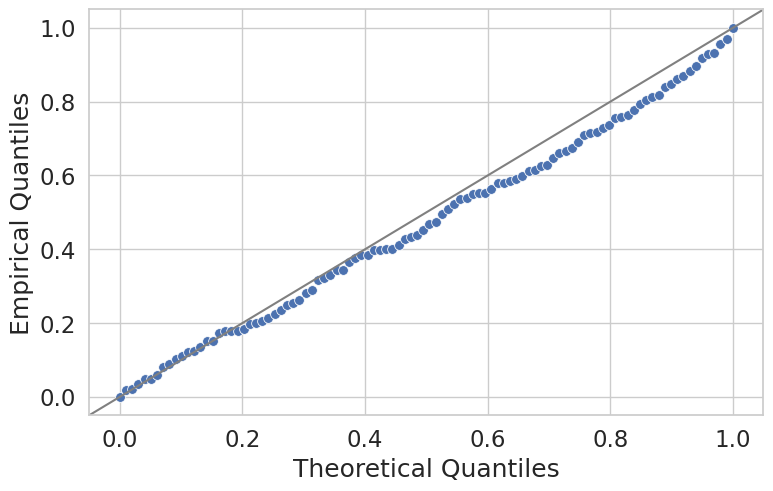

In [33]:
g = plot_calibration_curve(preds)
g

### **2. NGBoost - Mordred features**

R2 score: 0.9172308846100752


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

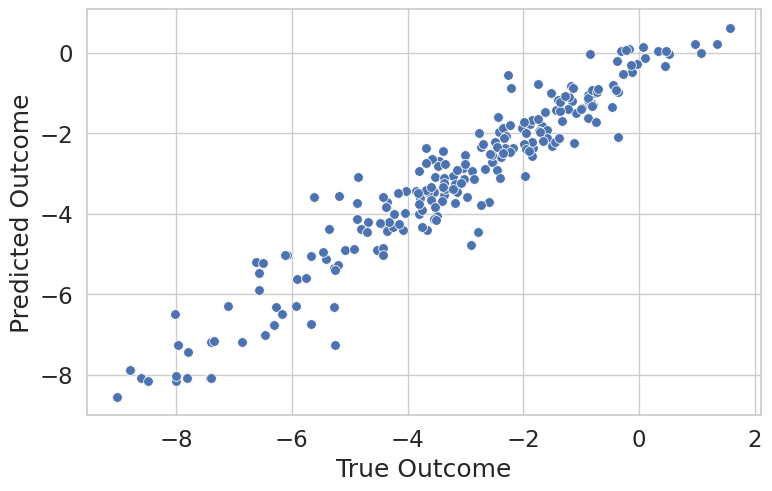

In [34]:
feature_set = "features_mordred"
preds = np.load(f'{data_dir}predictions_NGB_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

And its calibration plot

<Axes: xlabel='True Outcome', ylabel='Predicted Outcome'>

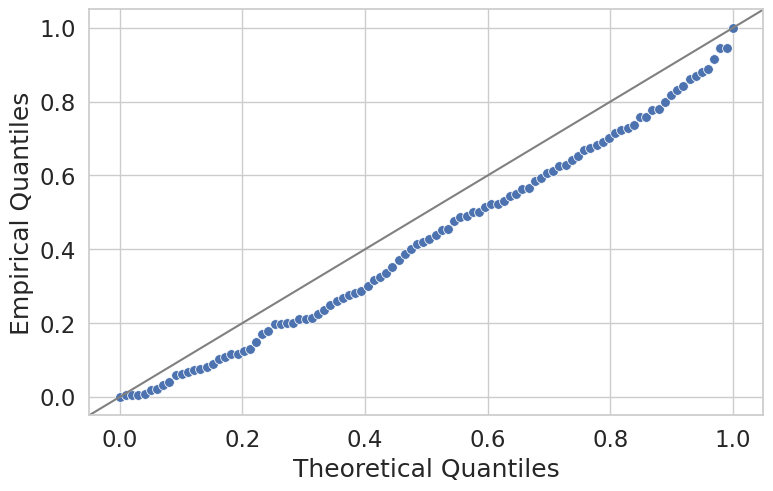

In [35]:
g = plot_calibration_curve(preds)
g

### **3. GPR - MFP features**

R2 score: 0.7772978910947296


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

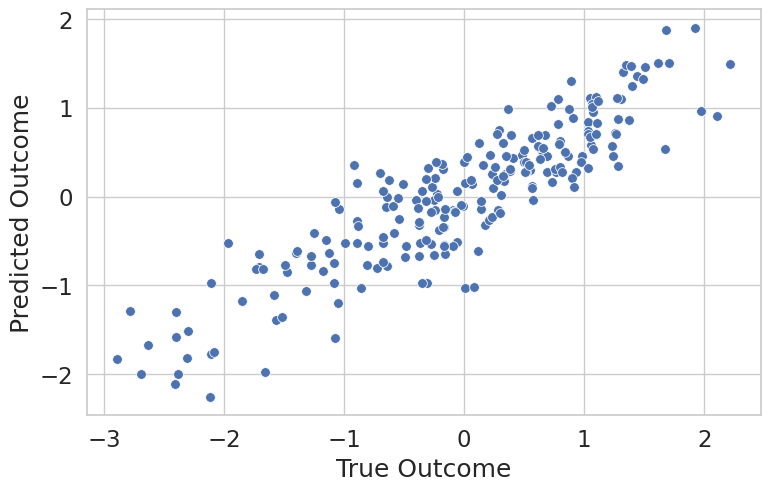

In [36]:
feature_set = "features_mfp"
preds = np.load(f'{data_dir}predictions_GPr_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

Calibration plot

<Axes: xlabel='True Outcome', ylabel='Predicted Outcome'>

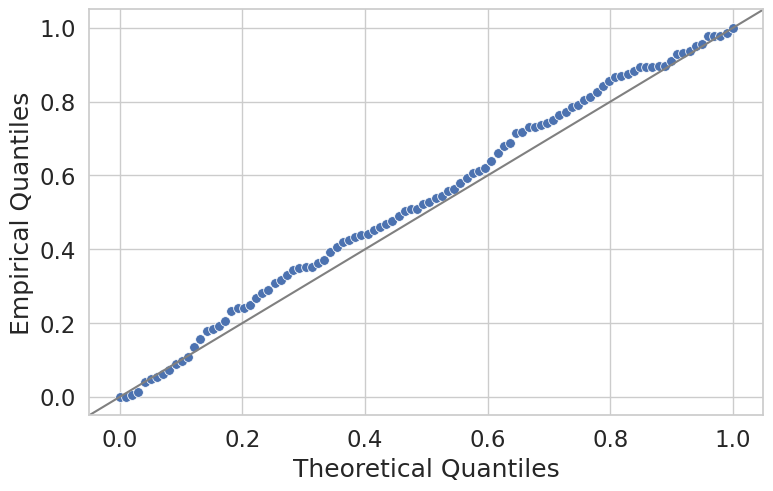

In [37]:
g = plot_calibration_curve(preds)
g

### **4. GPR - Mordred features**

R2 score: 0.9047315633146747


[Text(0.5, 0, 'True Outcome'), Text(0, 0.5, 'Predicted Outcome')]

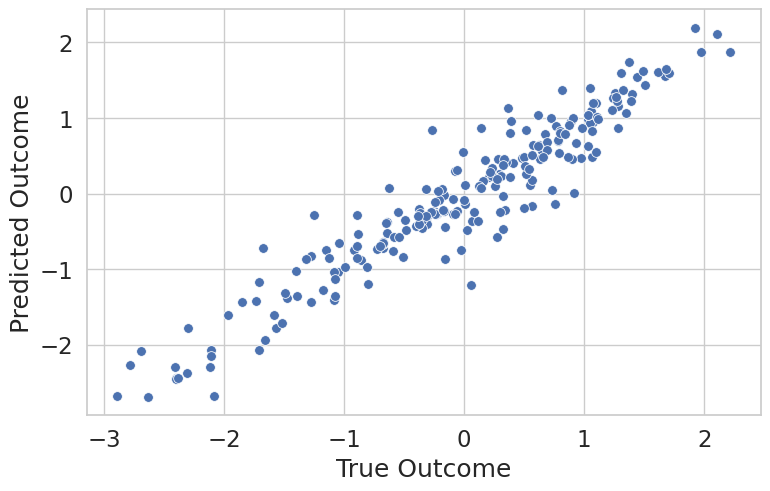

In [38]:
feature_set = "features_mordred"
preds = np.load(f'{data_dir}predictions_GPr_{feature_set}.npz')
preds = {key: preds[key] for key in preds.keys()}

print("R2 score:", r2_score(preds["y_true"].squeeze(), preds["y_pred"].squeeze()))
ax = sns.scatterplot(x = preds["y_true"].squeeze(), y = preds["y_pred"].squeeze())
ax.set(xlabel='True Outcome', ylabel='Predicted Outcome')

And its calibration plot

<Axes: xlabel='True Outcome', ylabel='Predicted Outcome'>

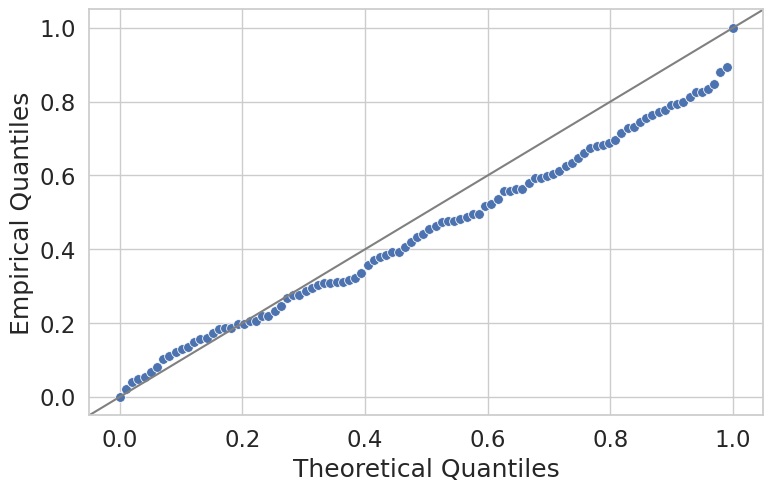

In [39]:
g = plot_calibration_curve(preds)
g